# Sparkify Project
Analysis of `mini_sparkify_event_data.json` dataset which is a subset of the full dataset before using the full datastet.

In [688]:
# import general libraries for data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import re

In [975]:
# import spark libraries
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import to_date, datediff
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col, sum, mean, stddev, min, max, round
from pyspark.sql import Window

from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

In [677]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Load and clean dataset `mini_sparkify_event_data.json`, checking for invalid or missing data.

## Load Dataset

In [678]:
mini_sparkify_event_data = 'mini_sparkify_event_data.json'

In [679]:
df = spark.read.json(mini_sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## Clean Dataset

`1.` Check for missing values:

In [70]:
# find number of missing values in dataset columns
columns = df.describe().columns[1:]
empy_vals = {}
for column in columns:
    # check for both nan and null values
    empy_vals[column] = (df.select(['userId']).where(isnan(df[column]) | df[column].isNull()).count())

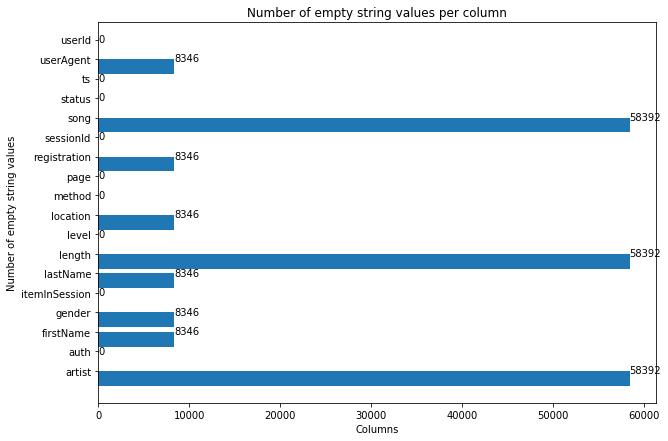

In [76]:
# plot the results with matplotlib

fig, ax = plt.subplots(figsize=(10, 7))  

width = 0.75 # the width of the bars 
ind = np.arange(len(empy_vals))  # the x locations for the groups
ax.barh(ind, list(empy_vals.values()), width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(list(empy_vals.keys()), minor=False)

for i, v in enumerate(list(empy_vals.values())):
    ax.text(v + 3, i + .25, str(v))

plt.title('Number of empty string values per column')
plt.xlabel('Columns')
plt.ylabel('Number of empty string values')      

plt.show()

We see that there are exactly the same numbers of missing values for some of the columns. This may mean that some columns are not filled in for specific kind of events. Let's explore our dataset to prove this:

In [88]:
# select columns with 8346 empty values
df.select(['userId','page', 'userAgent', 'registration', 'location', \
           'firstName', 'lastName', 'gender', 'song', 'length', 'artist']) \
.where(isnan(df['firstName']) | df['firstName'].isNull()).show()

+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|userId| page|userAgent|registration|location|firstName|lastName|gender|song|length|artist|
+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Help|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  n

In [95]:
# select userIds correponding to missing values in page, userAgent, registration
# location, firstName, lastName, gender columns

df.select(['userId']).where(df['firstName'].isNull() & df['userAgent'].isNull() & df['registration'].isNull() \
                            & df['location'].isNull() & df['lastName'].isNull() & df['gender'].isNull())\
.groupby('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+



So we see that rows with empty `userId`, which correspond to users, who are not signed in, have null values for `userAgent, registration, location, firstName, lastName, gender, song, length and artist` columns.

Other rows with empty `song, artist and length` columns probably correspond to other events, which are not related to listening to music, for example, upgrade or downgrade events. Let's look closer at the `page` column values corresponding to rows with empty `song, artist and length` columns.

In [91]:
# select page column values where song, artist and length columns are not null
df.select(['page']).where(df['song'].isNotNull() & df['length'].isNotNull() & df['artist'].isNotNull())\
.groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



We see that `song, artist and length` columns are filled in only for `NextSong` event.

`2.` Check for empty strings in string type colums:

In [25]:
# define list of string columns
columns_str = ['artist', 'auth', 'firstName', \
               'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

In [34]:
# for each column with type string find number of empty string values
empy_str_vals = []
for column in columns_str:
    empy_str_vals.append(df.select(['userId']).where(df[column] == '').count())

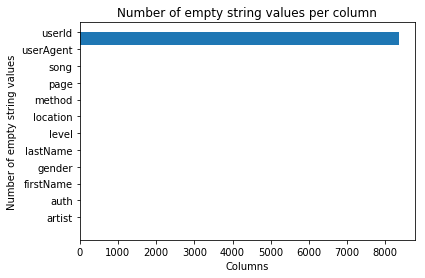

In [52]:
# plot the results with matplotlib

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(empy_str_vals))  # the x locations for the groups
ax.barh(ind, empy_str_vals, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(columns_str, minor=False)

plt.title('Number of empty string values per column')
plt.xlabel('Columns')
plt.ylabel('Number of empty string values')      

plt.show()

As we can see there are __empty string values in `userId` column__, which correspond to the users who are not signed in. As our task is to predict customer churn, we can __remove those records from the analysis__.

`3.` Check for invalid values in numeric columns:

In [57]:
df.describe(['itemInSession', 'length', 'sessionId', 'registration']).show()

+-------+------------------+------------------+-----------------+--------------------+
|summary|     itemInSession|            length|        sessionId|        registration|
+-------+------------------+------------------+-----------------+--------------------+
|  count|            286500|            228108|           286500|              278154|
|   mean|114.41421291448516|249.11718197783478|1041.526554973822|1.535358834085557...|
| stddev|129.76726201141113| 99.23517921058324|726.7762634630808|3.2913216163276587E9|
|    min|                 0|           0.78322|                1|       1521380675000|
|    max|              1321|        3024.66567|             2474|       1543247354000|
+-------+------------------+------------------+-----------------+--------------------+



In [56]:
df.describe(['status', 'ts']).show()

+-------+------------------+--------------------+
|summary|            status|                  ts|
+-------+------------------+--------------------+
|  count|            286500|              286500|
|   mean|210.05459685863875|1.540956889810471...|
| stddev|31.505078488422033| 1.507543960823119E9|
|    min|               200|       1538352117000|
|    max|               404|       1543799476000|
+-------+------------------+--------------------+



As we see numeric columns don't have any invalid values.

`4.` __Perform data cleaning__: the following function removes rows with empty `userId` from the dataset.

In [680]:
def clean_data(df):
    '''
    Function which performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify log events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column
    '''
    
    # remove rows where userId is empty
    df_new = df.filter(df["userId"] != "")
    
    return df_new

# clean data
df = clean_data(df)

# print out first line
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [426]:
df.count() # we see that rows with empty userId are removed from df

278154

# Exploratory Data Analysis

Exploratory data analysis for mini dataset, which is the subset of full dataset.

## 1. Preliminary Analysis

Get summary for the dataset:

In [703]:
print('There are {} lines in the dataset.  Each line corresponds to an event for a user, who signed in.'\
     .format(df.count()))

There are 278154 lines in the dataset.  Each line corresponds to an event for a user, who signed in.


In [697]:
print('There are {users} unique users in the dataset.'.format( users = df.select('userId').distinct().count()))

There are 225 unique users in the dataset.


Analyze categorical columns ('auth', 'gender', 'level', 'method', 'page'):

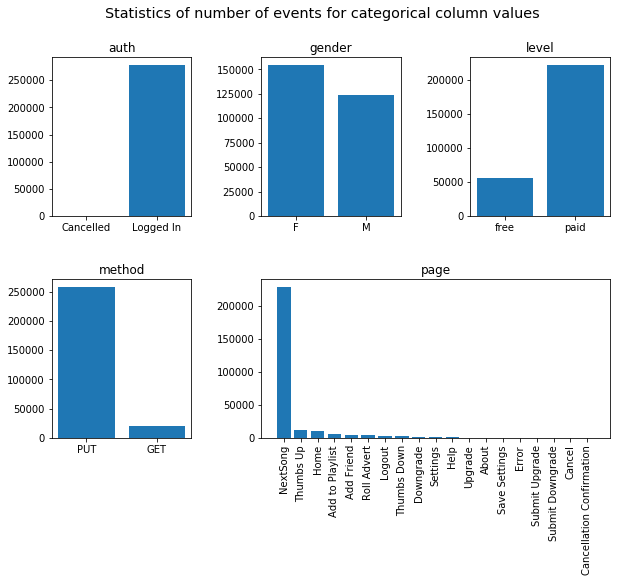

In [305]:
# plot bar charts with number of events with respect to categorical values

cat_columns = ['auth', 'gender', 'level', 'method']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)

counter = 0
for cat_column in cat_columns:
    
    value_counts = df.groupBy(cat_column).count().toPandas()
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    x_pos = np.arange(0, len(value_counts))
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    hist_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts[cat_column].values)
    
    hist_ax.set_title(cat_column)
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts = df.groupBy('page').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

page_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['page'].values)

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

The plot above shows us the following:
1. The number of events for female users is slightly greater than for male users. However this may be true only for our small dataset which is the subset of the full dataset.
2. The number of events for paid level accounts is approximately 4 times greater than the number of events for free level accounts.
3. The most popular action is 'NextSong' which is not surprising for a music streaming service.

In [344]:
# calculate the number of female and male users

male = df.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
female = df.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))

print('There are {male} male and {female} female users in dataset.'\
      .format(male = male.collect()[0]["count(count)"],\
             female = female.collect()[0]["count(count)"]))

There are 121 male and 104 female users in dataset.


In [348]:
# calculate the number of paid and free accounts

paid = df.select('userId', 'level').where(df.level == 'paid').groupBy('userId').count().agg(count("count"))
free = df.select('userId', 'level').where(df.level == 'free').groupBy('userId').count().agg(count("count"))

print('There are {paid} paid and {free} free accounts in dataset.'\
      .format(paid = paid.collect()[0]["count(count)"],\
             free = free.collect()[0]["count(count)"]))

There are 165 paid and 195 free accounts in dataset.


We see that the total number of accounts we calculated (165 + 195 = 360) is greater than total amount of users (121 + 104 = 225). This happened because one user can upgrade/downgrade his account, so when grouping by users we can get more records in total than the number of users.

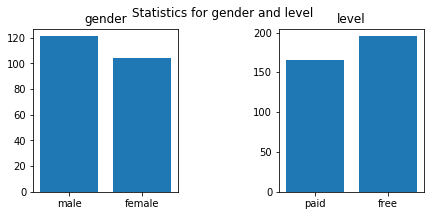

In [354]:
#plot the results

fig = plt.figure(figsize=(7, 3))
st = fig.suptitle("Statistics for gender and level")

grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.7)

x_pos = np.arange(0, 2)

gender_ax = fig.add_subplot(grid[0 , 0])

level_ax = fig.add_subplot(grid[0 , 1])

gender_ax.bar(x_pos, [male.collect()[0]["count(count)"], female.collect()[0]["count(count)"]], \
              tick_label = ['male', 'female'])
gender_ax.set_title('gender')

level_ax.bar(x_pos, [paid.collect()[0]["count(count)"], free.collect()[0]["count(count)"]], \
              tick_label = ['paid', 'free'])
level_ax.set_title('level')

plt.show()

The plot above tells us:
1. There are slightly more male users in mini dataset. But compairing with the previous plot where we saw more events for female users, we can say that female users more actively use the service than male users.
2. There are slightly more free accounts in mini dataset, but there are more events for paid users. This leads to a conclusion that users with paid accounts are more active using the service.

## 2. Define Churn

Create a column `churn` to label users who cancelled subscription and and mark rows for the users, who cancelled subscription, with `churn = 1`.

In [681]:
# create column Churn and mark rows for the users, who cancelled subscription, with Churn = 1

cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# set churn = 1 for rows where page == 'Cancellation Confirmation'
df = df.withColumn("churn", cancellation_event("page"))

In [682]:
# get userId with churn == 1
cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values

In [683]:
# set churn == 1 for all rows for users who cancelled their subscription

# create udf, which sets churn of a row to 1 if userId is in cancelled_users list
def fill_array(userId, features):
    if(userId in cancelled_users): return 1
    else : return 0

fill_array_udf = udf(fill_array, IntegerType())

df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))

Demonstrate log of events for one of the users who cancelled subscription:

In [183]:
df.select(['userId', 'firstName', 'page', 'churn']).where(df.userId == 125).toPandas()

,userId,firstName,page,churn
0,125,Mason,NextSong,1
1,125,Mason,NextSong,1
2,125,Mason,NextSong,1
3,125,Mason,NextSong,1
4,125,Mason,NextSong,1
5,125,Mason,NextSong,1
6,125,Mason,NextSong,1
7,125,Mason,NextSong,1
8,125,Mason,Roll Advert,1
9,125,Mason,Cancel,1


## 3. Explore Data

Perform exploratory data analysis to observe the behavior for users who stayed vs users who churned.

`3.1` Explore number of users who churned vs number of users who stayed with the service:

In [304]:
# find the number of users who churned and who stayed
churned_users = df.select('userId').where(df['churn'] == 1).groupBy('userId').count().count()
stayed_users = df.select('userId').where(df['churn'] == 0).groupBy('userId').count().count()

print('The number of users who churned is {}'.format(churned_users))
print('The number of users who didn\'t cancel subscription is {}'.format(stayed_users))

The number of users who churned is 52
The number of users who didn't cancel subscription is 173


We can see that __the dataset is imbalanced__: number of users who churned is approximately 3 times less than the number of users who stayed. That is why __accuracy is probably not the best metric to evaluate our future machine learning model__.

`3.2`  Explore number of events with respect to categorical columns for users who churned and for users who kept subscription:

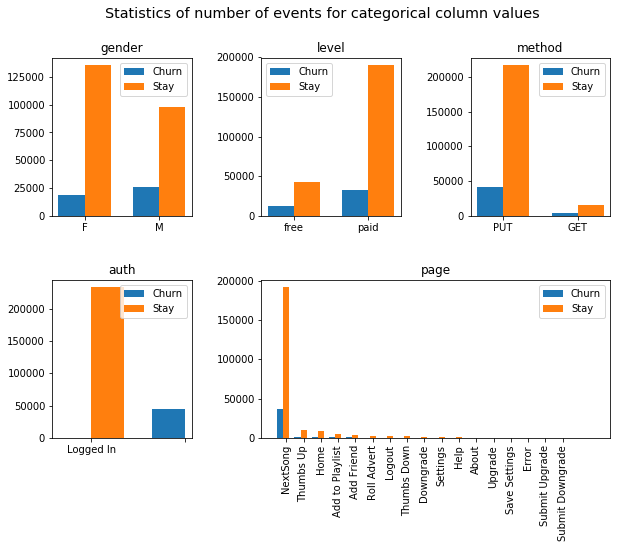

In [383]:
# plot bar charts with values of categorical values

cat_columns = ['gender', 'level', 'method', 'auth']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)
width = 0.35

counter = 0
for cat_column in cat_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    value_counts_ch = df.where(df['churn'] == 1).groupBy(cat_column).count().toPandas()
    value_counts_st = df.where(df['churn'] == 0).groupBy(cat_column).count().toPandas()
    
    x_pos_ch = np.arange(0, len(value_counts_ch))
    x_pos_st = np.arange(0, len(value_counts_st))
        
    p1 = hist_ax.bar(x_pos_ch, value_counts_ch['count'].values, width, \
                     tick_label = value_counts_ch[cat_column].values)
    p2 = hist_ax.bar(x_pos_st + width, value_counts_st['count'].values, width, \
                     tick_label = value_counts_st[cat_column].values)
    
    hist_ax.set_title(cat_column)
    hist_ax.set_xticks(x_pos + width / 2)
    
    hist_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts_ch = df.where(df['churn'] == 1).groupBy('page').count().orderBy('count', ascending=False).toPandas()
value_counts_st = df.where(df['churn'] == 0).groupBy('page').count().orderBy('count', ascending=False).toPandas()
    
x_pos_ch = np.arange(0, len(value_counts_ch))
x_pos_st = np.arange(0, len(value_counts_st))

p1 = page_ax.bar(x_pos_ch, value_counts_ch['count'].values, width, tick_label = value_counts_ch['page'].values)
p2 = page_ax.bar(x_pos_st + width, value_counts_st['count'].values, width, \
                 tick_label = value_counts_st['page'].values)

page_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

The plot above tells us the following:
1. Despite the fact that there are more events for female than male users, number of events for churned male users is greater than for churned female users. That is why we can suppose that female users who churned are less active service users than those who stay with their subscription.
2. For all other categorical features, we see that there more events for specific value there are in dataset, the more events for this specific value correspond to churned users. So we can't make any conclusion out of that regarding behaviour of churned users.

`3.3` Explore the gender of churned users and account level:

In [371]:
# calculate number of churned male and female users

male = df.select('userId', 'gender', 'churn').where((df.gender == 'M') & (df.churn == 1))\
.groupBy('userId').count().agg(count("count"))
female = df.select('userId', 'gender').where((df.gender == 'F') & (df.churn == 1))\
.groupBy('userId').count().agg(count("count"))

male_ch = male.collect()[0]["count(count)"]
female_ch = female.collect()[0]["count(count)"]

print('There are {male} male and {female} female users who churned in the dataset.'\
      .format(male = male_ch, female = female_ch))

There are 32 male and 20 female users who churned in the dataset.


In [372]:
# calculate number of male and female users who didn't cancel their subscription

male = df.select('userId', 'gender', 'churn').where((df.gender == 'M') & (df.churn == 0))\
.groupBy('userId').count().agg(count("count"))
female = df.select('userId', 'gender').where((df.gender == 'F') & (df.churn == 0))\
.groupBy('userId').count().agg(count("count"))

male_st = male.collect()[0]["count(count)"]
female_st = female.collect()[0]["count(count)"]

print('There are {male} male and {female} female users who didn\'t cancel their subscription in the dataset.'\
      .format(male = male_st, female = female_st))

There are 89 male and 84 female users who didn't cancel their subscription in the dataset.


In [370]:
# calculate the number of paid and free accounts related to churned users

paid = df.select('userId', 'level').where((df.level == 'paid') & (df.churn == 1))\
.groupBy('userId').count().agg(count("count"))
free = df.select('userId', 'level').where((df.level == 'free') & (df.churn == 1))\
.groupBy('userId').count().agg(count("count"))

paid_ch = paid.collect()[0]["count(count)"]
free_ch = free.collect()[0]["count(count)"]

print('There are {paid} paid and {free} free accounts related to churned users in the dataset.'\
      .format(paid = paid_ch, free = free_ch))

There are 36 paid and 46 free accounts related to churned users in the dataset.


There are only 52 users, who churned, and having 82 (36 + 46) accounts related to churned users means that 30 of users had both paid and free account levels. 

In [369]:
# calculate the number of paid and free accounts related to users who didn't cancel their subscription

paid = df.select('userId', 'level').where((df.level == 'paid') & (df.churn == 0))\
.groupBy('userId').count().agg(count("count"))
free = df.select('userId', 'level').where((df.level == 'free') & (df.churn == 0))\
.groupBy('userId').count().agg(count("count"))

paid_st = paid.collect()[0]["count(count)"]
free_st = free.collect()[0]["count(count)"]

print('There are {paid} paid and {free} free accounts related to users who didn\'t cancel their subscription in the dataset.'\
      .format(paid = paid_st,\
             free = free_st))

There are 129 paid and 149 free accounts related to users who didn't cancel their subscription in the dataset.


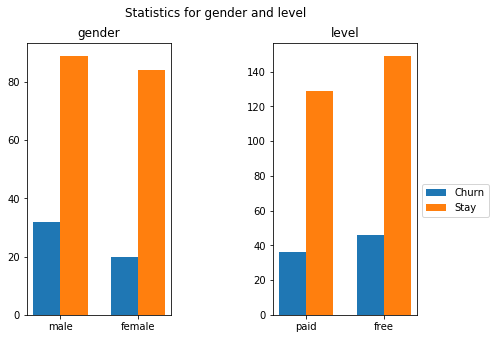

In [393]:
# plot the results

fig = plt.figure(figsize=(7, 5))
st = fig.suptitle("Statistics for gender and level")

grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.7)

x_pos = np.arange(0, 2)
width = 0.35

gender_ax = fig.add_subplot(grid[0 , 0])

level_ax = fig.add_subplot(grid[0 , 1])

g1 = gender_ax.bar(x_pos, [male_ch, female_ch], width, tick_label = ['male', 'female'])
g2 = gender_ax.bar(x_pos + width, [male_st, female_st], width, tick_label = ['male', 'female'])

gender_ax.set_title('gender')

gender_ax.set_xticks(x_pos + width / 2)

p1 = level_ax.bar(x_pos, [paid_ch, free_ch], width, tick_label = ['paid', 'free'])
p2 = level_ax.bar(x_pos + width, [paid_st, free_st], width, tick_label = ['paid', 'free'])

level_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'), bbox_to_anchor=(1, 0.5))

level_ax.set_title('level')
level_ax.set_xticks(x_pos + width / 2)

plt.show()

In [401]:
print('Percentage of female users who churned is {:.2f}%'.format(100 * female_ch / (female_ch + female_st)))

Percentage of female users who churned is 19.23%


In [400]:
print('Percentage of male users who churned is {:.2f}%'.format(100* male_ch / (male_ch + male_st)))

Percentage of male users who churned is 26.45%


In [405]:
print('Percentage of paid accounts related to users who churned {:.2f}%'.format(100 * paid_ch / (paid_ch + paid_st)))

Percentage of paid accounts related to users who churned 21.82%


In [404]:
print('Percentage of free accounts related to users who churned is {:.2f}%'.format(100 * free_ch / (free_ch + free_st)))

Percentage of free accounts related to users who churned is 23.59%


From the plot above we learn that:
1. There are less female users than male users and also fewer number of female users who churned.
2. Percentage of male users who churned is greater than percentage of female users, who churned.
3. Percentage of paid accounts related to users who churned is almost as the same as the percentage of free accounts related to users who churned.

`3.4` Explore average song length for users who churned vs users who stayed:

In [436]:
# calculate average song length for the users who churned

avg_length = df.where(df.churn == 1).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+------------------+
|              mean|               std|
+------------------+------------------+
|248.63279564406176|102.38497717575473|
+------------------+------------------+



In [437]:
# calculate average song length for the users who stayed

avg_length = df.where(df.churn == 0).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+----------------+
|              mean|             std|
+------------------+----------------+
|249.20913538880765|98.6258830014687|
+------------------+----------------+



We see that average song length for users who churned is very close to the average song length for the other users.

`3.5`  Explore userAgent column:

In [686]:
# create column for parsed agent
def get_agent(agent):
    agent = agent.split()[0]
    return re.sub(r'[^\w\s]','',agent)
    
get_agent_udf = udf(get_agent, StringType())
df = df.withColumn('agent', get_agent_udf(col('userAgent')))

In [689]:
# select all agent values
df.select('agent').distinct().show()

+---------+
|    agent|
+---------+
|Mozilla50|
+---------+



We see that the 1st user agent is Mozilla for all users. So this column is not informative for mini dataset.

`3.6` Explore location column:

In [708]:
# create column for state for each event

def get_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()
    
    return location
    
get_state_udf = udf(get_state, StringType())
df = df.withColumn('state', get_state_udf(col('location')))

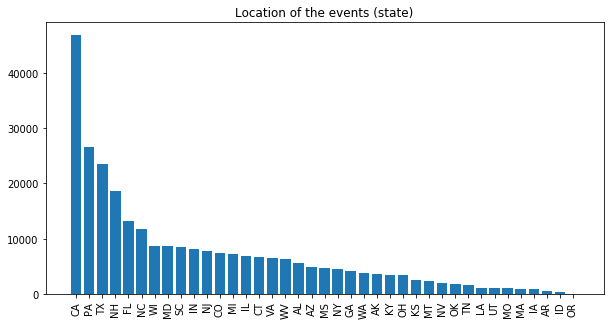

In [720]:
# plot statistics for location of the events
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

value_counts = df.groupBy('state').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['state'].values)

ax.set_title('Location of the events (state)')
    
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [971]:
# calculate number of events for users who churned/stayed for each state

value_counts_ch = df.where(df['churn'] == 1).groupBy('state').count().toPandas().sort_values('state')
value_counts_st = df.where(df['churn'] == 0).groupBy('state').count().toPandas().sort_values('state')

In [972]:
churn_states = value_counts_ch['state'].values.tolist()
for state in value_counts_st['state'].values.tolist():
    if state not in churn_states:
        value_counts_ch = value_counts_ch.append({'state' : state, 'count' : 0}, ignore_index=True)
        
stay_states = value_counts_st['state'].values.tolist()
for state in value_counts_ch['state'].values.tolist():
    if state not in stay_states:
        value_counts_st = value_counts_st.append({'state' : state, 'count' : 0}, ignore_index=True)

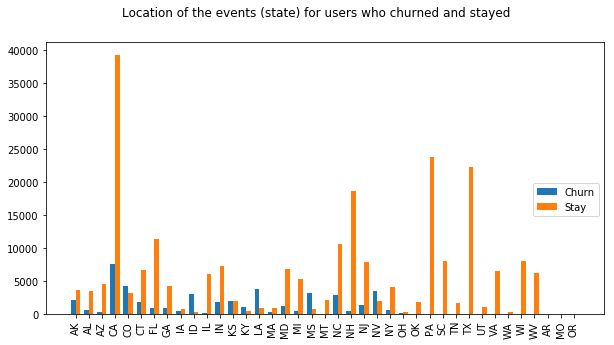

In [973]:
# plot the results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

st = fig.suptitle("Location of the events (state) for users who churned and stayed")

x_pos = np.arange(0, len(value_counts_st['count'].values))
width = 0.35

p1 = ax.bar(x_pos, value_counts_ch['count'].values.tolist(), width, tick_label = value_counts_ch['state'].values.tolist())
p2 = ax.bar(x_pos + width, value_counts_st['count'].values.tolist(), width, tick_label = value_counts_st['state'].values.tolist())

ax.legend((p1[0], p2[0]), ('Churn', 'Stay'), bbox_to_anchor=(1, 0.5))

level_ax.set_title('level')
ax.set_xticks(x_pos + width / 2)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

### `3.6` __Conclusions__:
1. From the exploratory analysis above we learn that behavior of female users is different compairing to behavior of male users:
    * Female users are more active: there are fewer female users, but there are more events related to female users.
    * Percentage of male users who churned is greater than percentage of female users, who churned, so male users may be more likely to churn.
2. Female users who churned have different behavior rather than other female users: female users whi churned are less active users of the service.

# Feature Engineering

To predict whether the user is going to churn for each user we will extract the following features:
* __gender__, because EDA showed us that male and female users may have different behavior;
* __last level (paid or free)__, because we see that paid level users are more active and also may have different behavior;
* __average events per day__ to see how active the user is in general;
* __average songs per day__ to see how active the user is in listening to the music;
* __number of thumbs up__ to see how satisfied the user is with the content of the service;
* __number of thumbs down__ to see how satisfied the user is with the content of the service;
* __days since the date of first event__ to see how long the user has already been using the service;
* __last location (state)__ the popularity may vary depending on advertising in different regions;
* __number of add friend events__ perhaps the user is less likely to churn if his friends are also subscribed to the service.

In [974]:
def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - number of thumbs up events
    6. thumbs_down - number of thumbs down events
    7. active_days - days since user's firts event
    8. last_location - location of the last event
    9. last_level - user's last level (paid or free)
    10. addfriends - number of add friends events
    '''
    
    # clean dataset using clean_data function
    df = clean_data(df)
    
    # add 'churn' column to the original dataset
    
    # define cancellation udf
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    
    # set churn = 1 for rows where page == 'Cancellation Confirmation'
    df = df.withColumn("churn", cancellation_event("page"))
    
    # get userId with churn == 1
    cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    # create udf, which sets churn of a row to 1 if userId is in cancelled_users list
    def fill_array(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    # set churn == 1 for all rows for users who cancelled their subscription
    fill_array_udf = udf(fill_array, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
    
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))
    
    # convert timestamp to date (string)
    def get_date_from_ts(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date_from_ts, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts')))
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts')))
    
    # add column date and convert timetamp to date
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    # set column last_level to level when timestamp is last timestamp
    df = df.withColumn('last_level',when(df.last_ts == df.ts, df.level))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # create column avg_songs to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
    
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    get_state_udf = udf(get_state, StringType())
    df = df.withColumn('state', get_state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')

    # assemble everything into resulting dataset
    df_ml = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId).distinct()
    df_ml = df_ml.join(events, df_ml.userId == events.events_userId).distinct()
    df_ml = df_ml.join(thumbsup, df_ml.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbsdown, df_ml.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.join(addfriend, df_ml.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['addfriend'])
    df_ml = df_ml.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ml
    
df = spark.read.json(mini_sparkify_event_data)
df.persist()

df, df_ml = prepare_dataset(df)

In [735]:
df_ml.show()

+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|userId|gender|churn|last_level|days_active|last_state|avg_songs|avg_events|thumbs_up|thumbs_down|addfriend|
+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|    89|     M|    0|      paid|        178|        GA|   111.17|     133.5|       30|          6|       14|
|   148|     M|    0|      free|        181|        FL|    36.18|     47.09|       28|          3|        7|
|200015|     M|    1|      free|        184|        CA|    28.67|      34.9|       10|         10|        2|
|    93|     M|    0|      paid|        186|        NJ|    58.18|     74.09|       35|          4|       13|
|300022|     M|    0|      paid|        179|        KY|    40.44|     49.56|       25|          5|       11|
|    64|     M|    0|      free|        170|        TX|    15.33|     22.67|        4|          0|        5|
|    79|     M|    

In [843]:
df_ml.count()

225

# Modeling

## `1.` Split into Train, Test and Validations Sets:

In [844]:
# split into train, test and validation sets (60% - 20% - 20%)
df_ml = df_ml.withColumnRenamed("churn", "label")

train, test_valid = df_ml.randomSplit([0.6, 0.4], seed = 42)
test, validation = test_valid.randomSplit([0.5, 0.5], seed = 42)

## `2.` Create Machine Learning Pipelines:

 `2.1` Random Forest Classifier:

In [862]:
# index and encode categorical features gender, level and state

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

# initialize random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

In [863]:
model = pipeline.fit(train)

In [864]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [865]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.8273381294964028


In [866]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 1.0


Tune parameters for Random Forest classifier:

In [897]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

In [898]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [899]:
cvModel = crossval.fit(train)

In [901]:
bestModel = cvModel.bestModel

In [902]:
pred_test = bestModel.transform(test)

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.4


 `2.2` Logistic Regression classifier:

In [880]:
# initialize logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoderGender, \
                             encoderLevel, encoderState, assembler, lr])

In [881]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [882]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7697841726618705


In [883]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 1.0


 `2.3` Gradient-boosted tree classifier:

In [887]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoderGender, \
                             encoderLevel, encoderState, assembler, gbt])

In [888]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [889]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.9856115107913669


In [890]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.9333333333333333


 `2.4` Naive Bayes classifier:

In [893]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoderGender, \
                             encoderLevel, encoderState, assembler, nb])

In [894]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [895]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.5323741007194245


In [896]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.4


# Conclusion

In this notebook we went through the process from data exploration to modeling.
<b>Mini dataset is too small (test and validation sets have only 15 records), so we can't really evaluate models. To be able to evaluate models we should user medium dataset or the whole dataset.